# Learn simple layer of LSTM


See the installation file to be able to run this file. 
If you find this file usefull, please cite the corresponding ICASSP2018 doi reference in your work.

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""lstm for guitar signal with input feature for gain parameters, jupyter notebook version"""
import os
import sys
sys.path.append('Codes')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from dataShaping import *
from savePerf import *
import scipy.io.wavfile
import time
from tensorflow.python.tools import freeze_graph


modelName = "LSTM9_ICASSP"
# create directory experiment
date = time.strftime("%Y-%m-%d-%H-%M")
path = os.path.join("experiments",date)
if not os.path.isdir(path):
    os.makedirs(path)
    #experiment/"date"/temp will contain the backuped model parameters
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
    # if you run the file two time in a minute
else :
    date = date+'(2)'
    path = os.path.join("experiments",date)
    os.makedirs(path)
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
	
# directory that will contain tensorboard information
pathLog = 'tf_logs'
if not os.path.isdir(pathLog):
    os.makedirs(pathLog)
pathLog = "{}/run-{}/".format(pathLog,date)

version = tf.__version__
print ("version {} of tensorflow".format(version))

#############################
# Model parameters
#############################
trainTestRatio = 0.9
#if you cannot load all the data set in Ram specify wich part you want to load (0 means all the dataset)
maxSize = int(np.floor(44100*11.4))
num_step = 50                                          #time step
num_hidden = 200                                      #num of hidden units
num_class = 1                                          #size of the output
num_feature = 1                                        # size of the input
batch_size = 600                                      # number of sequence taken before to compute the gradient
n_layer =1                                             #num_layer
num_epoch = 100000                                       # process all the datas num_epoch times
trainDuration = 60                              # or during a determined duration(second)
fileName = 'Datasets/training.mat'             #dataset train/test path
fileNameValidation = 'Datasets/validation.mat' # dataset validation path


#############################
# Loading data
#############################
matrix = sio.loadmat(fileName)
matrix = matrix['training']
if maxSize ==0:
    maxSize = len(matrix)
    print(maxSize)
# to do shuffle matrix by num_step length
train_input,train_output,test_input,test_output = splitShuffleData(matrix,num_step,trainTestRatio,maxSize)
print("shape input train {}".format(np.shape(train_input)))
numTrain = len(train_output)
print ("Data loaded")
#######################
#Graph
#######################

G = tf.Graph()
with G.as_default():
    with tf.name_scope("placeHolder"):
        data = tf.placeholder(tf.float32, [None, num_step], name ="data") #Number of examples, number of input step (time step), dimension of each input
        target = tf.placeholder(tf.float32, [None, num_class],name = "target") # batchSize, nbClass

    dataShaped = tf.reshape(data,[tf.shape(data)[0],num_step,num_feature])
    
    def lstm_cell():
        return tf.contrib.rnn.LSTMCell(num_hidden,state_is_tuple=True,activation = tf.nn.tanh)
    
    multiLayerCell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(n_layer)] )

    with tf.name_scope("extractLastValueLSTM"):
        val, state = tf.nn.dynamic_rnn(multiLayerCell, dataShaped, dtype=tf.float32) # val dim is [batchSize,num_step, numhidden]
    # Let's first fetch the last index of seq length
    # last_index would have a scalar value
        last_index = tf.shape(val)[1] - 1
    # Then let's reshape the output to [sequence_length,batch_size,numhidden]
    # for convenience
        val = tf.transpose(val,[1,0,2])
    # Last state of all batches
        #last = tf.nn.embedding_lookup(val,last_index) # tensor [batchsize,numhidden]
        last = tf.gather(val, num_step - 1)

    #Send the output of the lsat LSTM cell into a Fully connected layer to compute the prediciton pred[n]  
    with tf.name_scope("FCLayer"):
        weight = tf.get_variable("weight", shape=[num_hidden, int(target.get_shape()[1])], initializer=tf.contrib.layers.xavier_initializer())
        bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))

    prediction = tf.nn.elu((tf.add(tf.matmul(last, weight) , bias)),name = "prediction") #[batchSize,nclass]

    #Compute the mean square error
    MSE = tf.reduce_mean(tf.square(prediction-target))
    
    # create optimizer
    optimizer = tf.train.AdamOptimizer()
    #Compute gradient and apply backpropagation
    minimize = optimizer.minimize(MSE)

    # Create summary view for tensorboard
    mse_summary = tf.summary.scalar('RMSE',tf.sqrt(MSE))
    summary_op = tf.summary.merge_all()
    
    #Create an init op to initialize variable
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver() # save variable, use saver.restore(sess,"date/tmp/my_model.ckpt") instead of sess.run(init_op)

##############################
# Execution du graphe
##############################
    
with tf.Session(graph=G) as sess:
    #restorePath = os.path.join('2017-09-11-18-07','temp','my_model.ckpt') # example for restore a previous model
    #saver.restore(sess,restorePath)
    sess.run(init_op)
    train_writer = tf.summary.FileWriter(pathLog+'train',graph =tf.get_default_graph())
    test_writer = tf.summary.FileWriter(pathLog+'test')

    no_of_batches = int(np.floor((numTrain)/batch_size)) # numtrain -numstep ?
    no_of_batchesTest = int(np.floor((len(test_input))/batch_size))
    tStart = time.clock()
    epoch =0
    for epoch in range(num_epoch):
        if (time.clock()-tStart < trainDuration):
            ptr = 0
            if epoch % 10==0 : # each ten epoch save the model
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myGraph.pb',as_text=False)
                save_path = saver.save(sess,os.path.join(pathTemp,'my_model.ckpt'))
            for j in range(no_of_batches):
                inp, out = train_input[ptr:ptr+batch_size],train_output[ptr:ptr+batch_size]
                
                ptr+=batch_size
                if j % np.floor(trainTestRatio*10) ==0 : # This is to have a train summary and a test summary of the same size
                    _,summary_str = sess.run([minimize,summary_op],{data: inp, target: out})
                    step = epoch*no_of_batches+j
                    train_writer.add_summary(summary_str,step)
                else :
                    sess.run([minimize],{data: inp, target: out})
                   
                #print value
            print ("Epoch -{} calculated ".format(epoch))
            # evaluate the model on the test set (compute the mean of the MSE)
            pMSE = 0
            ptr2 = 0
            for k in range(no_of_batchesTest):
                pMSETemp,summary_str = sess.run([MSE,summary_op],{data: test_input[ptr2:ptr2+batch_size] , target: test_output[ptr2:ptr2+batch_size]})
                pMSE += pMSETemp
                ptr2+=batch_size
                step = epoch*no_of_batchesTest+k
                test_writer.add_summary(summary_str,step*10*trainTestRatio)
            print("Epoch {} MSE {} on test set".format(epoch,np.sqrt(pMSE/no_of_batchesTest)))
        else : break # break the while loop if number of epoch is reached
    tStop = time.clock()
    trainTime = time.strftime("%d:%H:%M:%S ", time.gmtime(tStop-tStart))
    
    #######################
    # Save Graph variable and information about the running session
    #######################
    # save graph model
    tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myFinalGraph.pb',as_text=False)
    # Save checkpoint variables
    save_path = saver.save(sess,os.path.join(pathTemp,'myFinalModel.ckpt'))
    print ("Training duration {}".format(trainTime))
    totalParameters =np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()])
    print("Number of training variable {}".format(totalParameters))
    # log
    infoLog={}
    infoLog["path"] = path
    infoLog["MSE"] = np.sqrt(pMSE/no_of_batchesTest)
    infoLog["num_step"] = num_step
    infoLog["num_hidden"] = num_hidden
    infoLog["num_epoch"] = epoch
    infoLog["batch_size"] = batch_size
    infoLog["maxSize"] = maxSize
    infoLog["duration"] = trainTime
    infoLog["totalParameters"] = totalParameters
    infoLog["version"] = version
    infoLog["n_layer"] = n_layer
    infoLog["trainDropout"] = 0
    infoLog["nameModel"] = modelName
    logPerf(infoLog)
    # freeze graph
    input_graph_path = "{}/".format(pathTemp)+'myFinalGraph.pb'
    checkpoint_path = "{}/".format(pathTemp)+'myFinalModel.ckpt'
    input_saver_def_path = ""
    input_binary = True
    output_node_names = "prediction"
    restore_op_name = "save/restore_all"
    filename_tensor_name = "save/Const:0"
    output_frozen_graph_name = "{}/".format(pathTemp)+'frozenModel.pb'
    # output_optimized_graph_name = 'optimized_'+MODEL_NAME+'.pb'
    clear_devices = True
    freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                          input_binary, checkpoint_path, output_node_names,
                          restore_op_name, filename_tensor_name,
                          output_frozen_graph_name, clear_devices, "")
   
    
    ###############################
    #   validation dataset and emulate guitar signal
    ###############################
    matrixVal = sio.loadmat(fileNameValidation)
    matrixVal = matrixVal['validation']  
    # shape validation test
    val_input,val_output = shapeData(matrixVal,num_step,maxSize)
    lPrediction = []
    lTarget = []
    ptr3 = 0
    no_of_batchesVal = int(np.floor((len(val_input))/batch_size))
    for k in range(no_of_batchesVal):
        pPrediction,pTarget = sess.run([prediction,target],{data: val_input[ptr3:ptr3+batch_size], target: val_output[ptr3:ptr3+batch_size]}) 
        lPrediction.append(pPrediction)
        lTarget.append(pTarget)   
        ptr3+=batch_size
    #plt.show()scree
    predictionArray = np.array(lPrediction,dtype=np.float32).ravel()
    targetArray = np.array(lTarget,dtype=np.float32).ravel()
    scipy.io.wavfile.write(os.path.join(path,'prediction.wav'),44100,predictionArray)
    scipy.io.wavfile.write(os.path.join(path,'target.wav'),44100,targetArray)

    # save emulation in a pickle format
    ax = plt.subplot(111)
    ax.plot(predictionArray[:10000],label='prediction')
    ax.plot(targetArray[:10000],label='target')
    ax.legend()
    nameFigEstimation = os.path.join(path,"targetVsPrediction.pickle")
    pickle.dump(ax,open(nameFigEstimation, 'wb'))
print ("done, good job kids")


version 1.3.0 of tensorflow
shape input train (452466, 50)
Data loaded


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch -0 calculated 
Epoch 0 MSE 0.1373166654335789 on test set
Epoch -1 calculated 
Epoch 1 MSE 0.12504083633521487 on test set
Training duration 01:00:01:14 
Number of training variable 30701
INFO:tensorflow:Restoring parameters from experiments/2017-10-31-16-10/temp/myFinalModel.ckpt
INFO:tensorflow:Froze 6 variables.
Converted 6 variables to const ops.
127 ops in the final graph.
done, good job kids


<IPython.core.display.Javascript object>


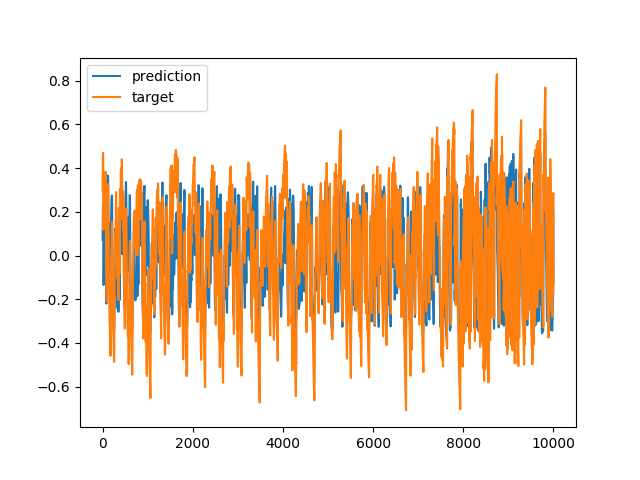

In [2]:
from show import *
%matplotlib notebook
showPickle(nameFigEstimation)